In [1]:
# Install Packages
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib_scalebar.scalebar import ScaleBar
#import seaborn as sns
import sklearn.metrics as sk
from scipy import stats
import time
import random
random.seed(a=37, version=2)

# from scipy.spatial import Voronoi, voronoi_plot_2d
# vor = Voronoi(predict_pts)
# voronoi_plot_2d(vor)
## https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
#import contextily as ctx
from shapely.ops import cascaded_union
from shapely.geometry import Point, Polygon, LineString
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

/home/ucfnhbx/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
novcolor = pd.read_csv(os.path.relpath("Data/ColorTablePCmap-20220627.txt"), sep='\t', header = None)
novcolor.columns = ['country', 'color']
#novcolor.loc[16,'color'] = 'red1'
# https://r-charts.com/colors/
novcolor.color[novcolor.color=='gold1'] = '#FFD700'
novcolor.color[novcolor.color=='orange'] = '#FFA500'
novcolor.color[novcolor.color=='tan3'] = '#CD853F'
novcolor.color[novcolor.color=='yellow'] = '#FFFF00'
novcolor.color[novcolor.color=='yellowgreen'] = '#9ACD32'
novcolor.color[novcolor.color=='gold2'] = '#EEC900'
novcolor.color[novcolor.color=='gold3'] = '#CDAD00'
novcolor.color[novcolor.color=='aquamarine4'] = '#458B74'
novcolor.color[novcolor.color=='aquamarine2'] = '#76EEC6'
novcolor.color[novcolor.color=='aquamarine3'] = '#66CDAA'
novcolor.color[novcolor.color=='darkolivegreen2'] = '#BCEE68'
novcolor.color[novcolor.color=='green2'] = '#00EE00'
novcolor.color[novcolor.color=='green3'] = '#00CD00'
novcolor.color[novcolor.color=='green4'] = '#008B00'
novcolor.color[novcolor.color=='green'] = '#00FF00'
novcolor.color[novcolor.color=='pink'] = '#FFC0CB'
novcolor.color[novcolor.color=='red#lightblue'] = '#FF0000' #red1
novcolor.color[novcolor.color=='lightpink3'] = '#CD8C95'
novcolor.color[novcolor.color=='yellow'] = '#FFFF00'
novcolor.color[novcolor.color=='sienna'] = '#A0522D'
novcolor.color[novcolor.color=='dodgerblue1'] = '#1E90FF'
novcolor.color[novcolor.color=='darkseagreen4'] = '#698b69'
novcolor.color[novcolor.color=='darkseagreen'] = '#8FBC8F'
novcolor.color[novcolor.color=='dodgerblue3'] = '#1874CD'
novcolor.color[novcolor.color=='cadetblue1'] = '#98F5FF'
novcolor.color[novcolor.color=='deepskyblue2'] = '#00B2EE'
novcolor.color[novcolor.color=='deepskyblue4'] = '#00688B'
novcolor.color[novcolor.color=='cadetblue'] = '#5F9EA0'
novcolor.color[novcolor.color=='cadetblue3'] = '#7ac5cd'
novcolor.color[novcolor.color=='cadetblue2'] = '#8EE5EE'
novcolor.color[novcolor.color=='deepskyblue1'] = '#00BFFF'
novcolor.color[novcolor.color=='blue'] = '#0000FF'
novcolor.color[novcolor.color=='darkorchid3 '] = '#9A32CD' 
novcolor.color[novcolor.color=='violetred1'] = '#FF3E96'
novcolor.color[novcolor.color=='violetred3'] = '#CD3278'
novcolor.color[novcolor.color=='palevioletred2 '] = '#EE799F'
novcolor.color[novcolor.color=='orange'] = '#FFA500'
novcolor.color[novcolor.color=='orangered1'] = '#FF4500'
novcolor.color[novcolor.color=='springgreen4'] = '#008B45'
novcolor.color[novcolor.color=='red'] = '#0000FF'

# Figure 1
## Data

In [3]:
# Load PCA results
pca = pd.read_csv(os.path.relpath("Data/Nov2008_PCA-20220622.txt"), delimiter='\t')

# Add color
pca = pd.merge(pca, novcolor, how = 'left', left_on = 'plabels', right_on = 'country')
pca.head()

,ID,plabels,alabels,longitude,latitude,PC1,PC2,RotNS,RotEW,country,color
0,474,Croatia,HR,16.100000,45.320000,0.0111,-0.0460,0.041140,0.023381,Croatia,#1874CD
1,660,Serbia and Montenegro,YG,20.615723,43.949493,-0.0300,-0.0443,0.050866,-0.016588,Serbia and Montenegro,#8EE5EE
2,1890,Czech Republic,CZ,15.376984,49.736607,0.0137,-0.0444,0.038884,0.025438,Czech Republic,#9ACD32
3,1923,Bosnia and Herzegovina,BA,17.862023,44.175876,0.0028,-0.0493,0.046606,0.016317,Bosnia and Herzegovina,#5F9EA0
4,2083,Serbia and Montenegro,YG,20.615723,43.949493,-0.0031,-0.0416,0.040836,0.008518,Serbia and Montenegro,#8EE5EE


In [4]:
# Add ID to novcolor for later
novcolor = pca[['ID', 'country', 'color']]
novcolor.head()

,ID,country,color
0,474,Croatia,#1874CD
1,660,Serbia and Montenegro,#8EE5EE
2,1890,Czech Republic,#9ACD32
3,1923,Bosnia and Herzegovina,#5F9EA0
4,2083,Serbia and Montenegro,#8EE5EE


In [5]:
# Make bbox for Europe area of interest
ymin, xmin, ymax, xmax = [34.802386, -10.661639, 71.184162, 44.820366]

bboxdf = {'geometry': [Polygon([
    (xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin)
])]}
bbox = gpd.GeoDataFrame(bboxdf, crs="EPSG:4326")
bbox.total_bounds
bbox.geometry
# should only percolate the ones in the bounding box  = 

0    POLYGON ((-10.66164 34.80239, -10.66164 71.184...
Name: geometry, dtype: geometry

<AxesSubplot:>

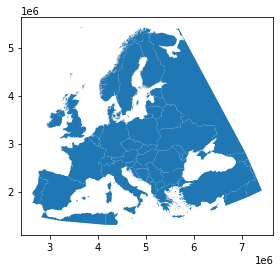

In [6]:
# world countries
countries = gpd.read_file(os.path.relpath('Data/CNTR_RG_01M_2020_4326.geojson'))

# clip world countries to bbox
europ = gpd.clip(countries, mask=bbox, keep_geom_type=False).to_crs(epsg=3035)
europ.plot()

## Plotting

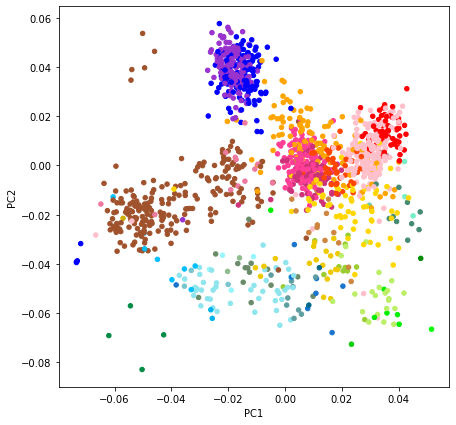

In [7]:
# Plot raw PC1 and PC2 per country; same as eigs 4.093 and 2.040
#pcaPCA = gpd.GeoDataFrame(pca, #.drop(columns=['longitude','latitude'],inplace=True)
                          #geometry=gpd.points_from_xy(pca.PC1, pca.PC2), crs="EPSG:4326")
#pcaPCA.plot(color=pcaPCA.color, figsize=(7,7)); 
raw, ax = plt.subplots()
pca.plot.scatter(x='PC1', y='PC2', color=pca.color, figsize=(7,7), ax=ax);
#raw.savefig(os.path.relpath('Figs/dna_1raw.png'), dpi=100) 

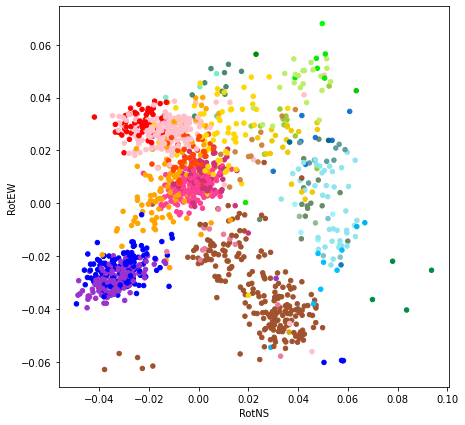

In [8]:
# Plot rotated PC1 and PC2 per country
#pcaROT = gpd.GeoDataFrame(pca, #.drop(columns=['PC1','PC2'],inplace=True), geometry=gpd.points_from_xy(pca.RotNS, pca.RotEW), crs = 'EPSG:4326')
#pcaROT.plot(color=pcaROT.color, figsize=(7,7)); #individuals PC1 and PC2 rotated values
rot, ax = plt.subplots()
pca.plot.scatter(x='RotNS', y='RotEW', color=pca.color, figsize=(7,7), ax=ax);
#rot.savefig(os.path.relpath('Figs/dna_1rot.png'), dpi=100) 

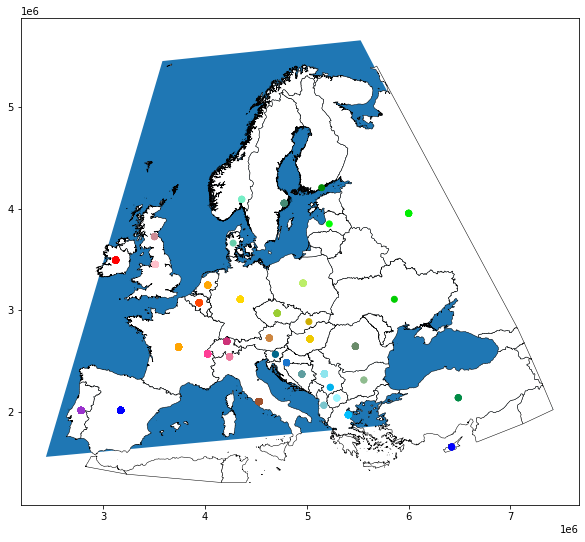

In [9]:
# Plot country centroids
pcaCENT = gpd.GeoDataFrame(pca, geometry=gpd.points_from_xy(pca.longitude, pca.latitude), crs="EPSG:4326").to_crs(epsg=3035)

fig1, ax = plt.subplots(figsize=(10,10))
bbox.to_crs(epsg=3035).plot(ax=ax)
europ.plot(ax=ax, color = 'white', edgecolor = 'black', linewidth = 0.5);
pcaCENT.plot(color=pcaCENT.color, ax=ax); #ax=base
#pca.plot.scatter(ax=ax, x='longitude', y='latitude', color=pca.color);
#fig1.savefig(os.path.relpath('Figs/dna_1.png'), dpi=100) 

# Figure 2
## Data

In [10]:
# leave-one-out cross validation and the continuous assignment method
predict = pd.read_csv(os.path.relpath("Data/Nov2008_predict-20220627.csv"))
predict = predict[['V1', 'V2', 'V3']]
predict_pts = predict[['V2','V3']].values
predict.columns = ['ID', 'Longitude', 'Latitude']
predict = pd.merge(predict, novcolor, how = 'left', on='ID')
predict = gpd.GeoDataFrame(predict, geometry=gpd.points_from_xy(predict.Longitude, predict.Latitude), crs="EPSG:4326").to_crs(epsg=3035)


# locations used to train the assignment method
true = pd.read_csv(os.path.relpath("Data/Nov2008_true-20220627.csv"))
true = true[['V1', 'V2', 'V3']]
true.columns = ['ID', 'Longitude', 'Latitude']
true = pd.merge(true, novcolor, how = 'left', on='ID')
true = gpd.GeoDataFrame(true, geometry=gpd.points_from_xy(true.Longitude, true.Latitude), crs="EPSG:4326").to_crs(epsg=3035)




## Plotting

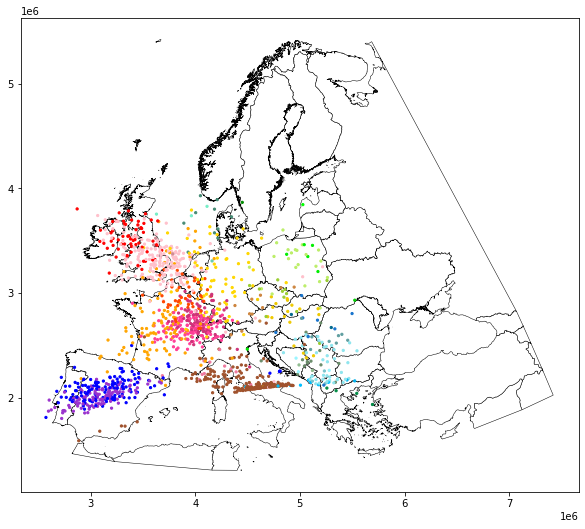

In [11]:
fig2, ax = plt.subplots(figsize=(10,10))
#ax.set_aspect('equal')
#ax.legend(novcolor.country, novcolor.color)
#fig.set_dpi(200)
europ.plot(ax=ax, color = 'white', edgecolor = 'black', linewidth = 0.5);
predict.plot(ax=ax, color=predict.color, markersize=5);
#true.plot(ax=ax, marker="2", color=predict.color, markersize=100);
plt.show();
#fig2.savefig(os.path.relpath('Figs/dna_2.png'), dpi=100) 

# Voronoi

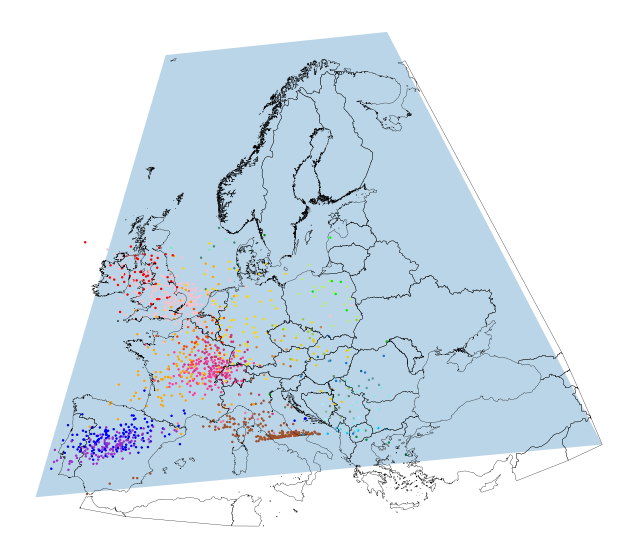

In [12]:
#Check it looks right
fig, ax = plt.subplots(figsize=(12, 10))
#ax.set_aspect('equal')
#europ.dissolve().convex_hull.plot(ax=ax, edgecolor='black', color = 'white')
europ.boundary.plot(ax=ax, edgecolor='black', linewidth=0.3)
bbox.to_crs(epsg=3035).plot(ax=ax, alpha=0.3)
predict.plot(ax=ax, color=predict.color, markersize=2);
#true.plot(ax=ax, color=predict.color, markersize=6);
ax.axis('off')
#plt.axis('equal')
plt.show()

In [13]:
# Load all PCA components, cleaning the columns
eigs = pd.read_fwf(os.path.relpath("Data/NovPCAeigs-20220627.txt"), width=[6,6,6,5,5])
eigs.columns = ['ID', '4.093', '2.040', 
                '1.537', #'1.435', 
                '1.387', '1.344', '1.343', 
                '1.339', #'1.337',
                '1.334', '1.331', '1.329', 
                '1.327', #'1.325', 
                '1.323', '1.322', '1.321', 
                '1.320', '1.319', '1.317',
                'control']
eigs[['1.537', '1.435']] = eigs['1.537'].str.split(expand=True)
eigs[['1.339', '1.337']] = eigs['1.339'].str.split(expand=True)
eigs[['1.327', '1.325']] = eigs['1.327'].str.split(expand=True)
eigs[['ID', 'ID2']] = eigs['ID'].str.split(expand=True)
eigs.drop(columns=['ID2', 'control'], inplace = True)
eigs = eigs.astype({'ID': 'int32'})
#eigs.set_index('DNAsample', inplace=True)
eigs.shape

(1387, 21)

In [14]:
# create voronoi polygons
euro_union = cascaded_union(bbox.to_crs(epsg=3035).geometry)
predict_nparray = points_to_coords(predict.clip(bbox.to_crs(epsg=3035)).geometry)
poly_shapes, pts = voronoi_regions_from_coords(predict_nparray, euro_union)

<ipython-input-14-e46eb6aad7d2>:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  euro_union = cascaded_union(bbox.to_crs(epsg=3035).geometry)


In [15]:
# make geodataframe from voronoi polygons
vor = gpd.GeoDataFrame()
for shape in poly_shapes:
    new = gpd.GeoDataFrame(crs='EPSG:4326', geometry=[poly_shapes[shape]]).to_crs(epsg=3035)
    vor = vor.append(new)

<ipython-input-15-351545b41e5a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vor = vor.append(new)
<ipython-input-15-351545b41e5a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vor = vor.append(new)
<ipython-input-15-351545b41e5a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vor = vor.append(new)
<ipython-input-15-351545b41e5a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vor = vor.append(new)
<ipython-input-15-351545b41e5a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vor = vor.append(new)
<ipython-input-15-351545b41e5a>:5: Futur

In [16]:
# add eigs from points
vor_predict = gpd.sjoin(vor, predict)
vor_eigs = pd.merge(vor_predict, eigs, on='ID', how='left')
vor_eigs.rename(columns={'index_right':'vor_index'}, inplace=True)

/home/ucfnhbx/.local/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


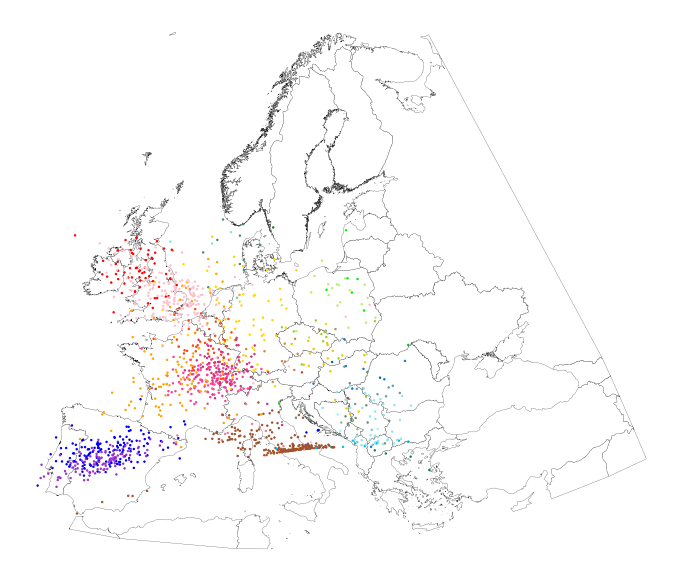

In [17]:
#Check it looks right
fig3, ax = plt.subplots(figsize=(12, 12))
#ax.set_aspect('equal')
europ.plot(ax=ax, color = "white", edgecolor="black", linewidth=0.2);
vor_eigs.plot(ax=ax, color = "white", edgecolor="green", linewidth=0.5, alpha=0.3);
predict.plot(ax=ax, color=predict.color, markersize=2);
ax.axis('off')
#plt.show()
fig3.savefig(os.path.relpath('Figs/dna_3.png'), dpi=100) 

# Cosine similarity

In [18]:
gdf_nodes = pd.read_csv("Data/nodesgeo.csv")
gdf_nodes = gpd.GeoDataFrame(gdf_nodes, geometry=gpd.points_from_xy(gdf_nodes.lon, gdf_nodes.lat), crs=3035)
gdf_nodes.drop(["lat","lon"], axis=1, inplace=True)
gdf_nodes = gdf_nodes.to_crs(crs=4326)
#gdf_nodes.head()

/home/ucfnhbx/.local/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


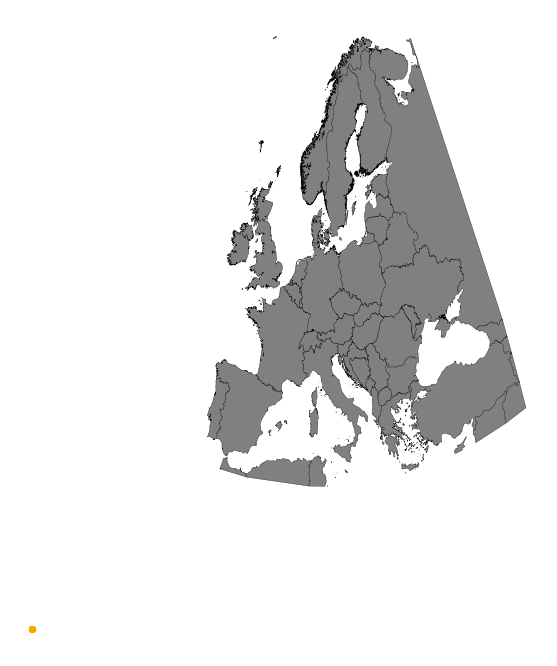

In [19]:
#Visualise spatial join with network
fig4, ax = plt.subplots(figsize=(12, 12))
europ.plot(ax=ax, color='grey', edgecolor="black", linewidth=0.3);
vor_eigs.plot(ax=ax, color = 'white', edgecolor="green", linewidth=0.3);
gdf_nodes.sample(200).plot(ax=ax, color = 'orange') #london
#gdf_nodes.plot(ax=ax, color = 'orange') #london
ax.axis('off')
plt.show()
#fig4.savefig(os.path.relpath('Figs/dna_4.png'), dpi=100) 

In [20]:
# percent of nodes without eigs
gdf_nodes_eigs0 = gpd.sjoin(gdf_nodes, vor_eigs.drop(columns=['vor_index', 'ID','Longitude', 'Latitude','country','color']), how='left')
gdf_nodes_eigs1 = gdf_nodes_eigs0[gdf_nodes_eigs0['1.537'].notna()]
percent = gdf_nodes_eigs1.shape[0]/gdf_nodes_eigs0.shape[0]
percent
#0.9973745246717564

<ipython-input-20-7966ef4fc3d6>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf_nodes_eigs0 = gpd.sjoin(gdf_nodes, vor_eigs.drop(columns=['vor_index', 'ID','Longitude', 'Latitude','country','color']), how='left')


0.0

In [21]:
#gdf_nodes_eigs = gpd.sjoin(gdf_nodes, vor_eigs.drop(columns=['vor_index', 'ID','Longitude', 'Latitude','country','color']), how='left')
#gdf_nodes_eigs = gdf_nodes_eigs[gdf_nodes_eigs['1.537'].notna()]
gdf_nodes_eigs = gdf_nodes_eigs1.astype('float64') #drop(columns=['geometry','index_right'], inplace=True).

In [22]:
#create results dataframe
sim = pd.DataFrame(columns = ['jump', 'cluster_id', 'n_points', 'g_sim', 'G_sim'])

# choose jump
j = 1500

# retrieve the nodes in this jump, #'id_point', 'id_cluster'
jump = pd.read_csv(os.path.relpath("run_spercolation_outputs/membTables/membership"+str(j)+'.txt'))

# cluster sizes in this jump
sizes = pd.read_csv(os.path.relpath("run_spercolation_outputs/cluster_sizes/clust_size_p"+str(j)+'.txt'), delimiter=" ")

# ten largest clusters
lccs=sizes.sort_values(by='n_points', axis=0, ascending=False).head(10)
#lccs.ID.unique()  

# nodes in ten largest clusters
lccs_nodes = pd.merge(jump, lccs, left_on='id_cluster', right_on="ID") #.add_suffix(level) 

# add eigs to nodes (nodes that have eigs)
lccs_nodes_eigs = pd.merge(gdf_nodes_eigs, lccs_nodes, how='inner', left_on = 'name', right_on='id_point')

In [23]:
#cluster id
c = 26312 

# nodes in cluster (with eigs)
c_nodes = lccs_nodes_eigs[lccs_nodes_eigs.id_cluster==c].loc[:, '1.537':'1.325'].reset_index()

# determine sample size based on cluster size 
N = round(c_nodes.shape[0] / 2000)

# nodes in network (with eigs)
all_nodes = gdf_nodes_eigs.loc[:, '1.537':'1.325'].reset_index()

In [24]:
# random sampling of pairs for cosine similarity
for n in range(N):

    # the cluster case
    gi1 = random.randint(a=1, b=c_nodes.shape[0])
    gi2 = random.randint(a=1, b=c_nodes.shape[0])
    gn1 = c_nodes.iloc[[gi1]]
    gn2 = c_nodes.iloc[[gi2]]
    gsim = sk.pairwise.cosine_similarity(gn1, gn2)[0][0]
    gsim = np.nan

    # the random case  
    Gi1 = random.randint(a=1, b=all_nodes.shape[0])
    Gi2 = random.randint(a=1, b=all_nodes.shape[0])
    Gn1 = all_nodes.iloc[[Gi1]]
    Gn2 = all_nodes.iloc[[Gi2]]
    Gsim = sk.pairwise.cosine_similarity(Gn1, Gn2)[0][0]

    # results in output dataframe
    sim_ = pd.DataFrame([[j, c, lccs.loc[[c]].n_points, gsim, Gsim]], columns=['jump', 'cluster_id', 'n_points', 'g_sim', 'G_sim'])

    sim = pd.concat([DNAsim, DNAsim_])

sim.head()   

,jump,cluster_id,n_points,g_sim,G_sim


In [25]:
ttest = stats.ttest_ind(a=sim.g_sim, b=sim.G_sim, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
ttest[0], ttest[1], sim.g_sim.mean(), sim.G_sim.mean()

(nan, nan, nan, nan)

In [26]:
DNAsim.to_csv(os.path.relpath("run_spercolation_outputs/cosine_DNA/j"+str(j)+"_c"+str(c)+'.csv')) 

NameError: name 'DNAsim' is not defined